In [1]:
%matplotlib inline

from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load

from random import choice
import numpy as np
import scipy as sp

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = 'Users/allisonmorgan/Documents/faculty_hiring/notebooks-productivity/figures/'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

## Profile the Schools

Pre-compute all information that we'll need in order to match pairs of schools

In [3]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
def publication_data(function = np.average, limit_by_years_post_hire=False, num_years=5):
    pubs_by_inst = {}
    prestige_map = {}
    for (name, inst_data) in inst.items():
        if name in ignore:
            continue
        current_faculty = faculty_at_institution(name, asst_faculty)
        n_pubs = []
        for person in current_faculty:
            start = person.first_asst_job_year
            if limit_by_years_post_hire:
                end = np.min([2012, person.first_asst_job_year + num_years])
            else:
                end = 2012
            career_length = end - start
                
            if person.__contains__('dblp_pubs'):
                contribution = 0 
                for pub in person.dblp_pubs:
                    if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                        contribution += inflation_adjust(pub['year'])
                pubs_per_year = contribution / career_length
                n_pubs.append(pubs_per_year)

        pubs_by_inst[name] = {"total_pubs_by_author": function(n_pubs), 
                              "status": inst_data['private'], 
                              "rank": inst_data['pi'],
                              "dept_size": len(n_pubs)} 
        prestige_map[inst_data['pi']] = name
    
    return (pubs_by_inst, prestige_map)

pubs_by_inst, prestige_map = publication_data(function=np.mean, limit_by_years_post_hire=False)

## Match Them

In [5]:
public = []
private = []

for place in pubs_by_inst:
    if pubs_by_inst[place]['rank'] >= 0 and place not in ignore:
        if pubs_by_inst[place]['status'] == 0:
            public.append((place, pubs_by_inst[place]))
        else:
            private.append((place, pubs_by_inst[place]))

In [6]:
print("There are %d public schools and %d private schools (%d total)." % (len(public), len(private), len(public)+len(private)))

There are 151 public schools and 53 private schools (204 total).


In [7]:
def get_matched_pairs(public, private, skip=0.0):
    pairs = []
    scores = []
    
    available = {}
    for name, _ in public:
        available[name] = True
    
    possible_matches = len(private)
    grab = (1-skip)*possible_matches
    num_matches = 0
    
    # Go through all private schools
    for p1, p1_data in private:
        best_score = np.inf
        
        best_match = ""
        # Find a matching public school
        for p2, p2_data in public:
            # Only consider this school if we haven't already deleted it
            if available.has_key(p2):
                # Match on rank
                score = abs(p2_data["rank"] - p1_data["rank"])
                if score < best_score:
                    best_match = p2
                    best_score = score
        
        del available[best_match]
        pairs.append((p1, best_match))
        scores.append(best_score)
 
        num_matches += 1
        if num_matches > grab:
            break
                
    return pairs, scores

In [9]:
np.random.shuffle(private)
pairs, scores = get_matched_pairs(public, private, skip=0.7)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

California Institute of Technology (Private)	<-->	UC Berkeley (Public)	Score: 2.930000
Stevens Institute of Technology (Private)	<-->	State University of New York, Buffalo (Public)	Score: 0.240000
Dartmouth College (Private)	<-->	University of Virginia (Public)	Score: 0.210000
Catholic University of America (Private)	<-->	Clemson University (Public)	Score: 0.410000
University of Pennsylvania (Private)	<-->	University of Wisconsin, Madison (Public)	Score: 1.190000
Pace University (Private)	<-->	New Mexico Institute of Mining and Technology (Public)	Score: 0.120000
University of Chicago (Private)	<-->	University of Texas, Austin (Public)	Score: 0.620000
Cornell University (Private)	<-->	University of Washington (Public)	Score: 2.770000
Brandeis University (Private)	<-->	McMaster University (Public)	Score: 0.540000
University of Notre Dame (Private)	<-->	Wayne State University (Public)	Score: 0.780000
University of Bridgeport (Private)	<-->	University of Arkansas, Fayetteville (Public)	Sc

In [275]:
total_trials = 0
num_positive = 0
advantages = []
diffs = []
rank_diffs = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(private)
    
    pairs,_ = get_matched_pairs(public, private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        assert inst[p1]['private'] == 1
        assert inst[p2]['private'] == 0
        
        private_university = 0
        published_more = np.argmax([pubs_by_inst[p1]["total_pubs_by_author"], pubs_by_inst[p2]["total_pubs_by_author"]])
        
        diff = pubs_by_inst[p1]["total_pubs_by_author"] - pubs_by_inst[p2]["total_pubs_by_author"]
        diffs.append(diff)
        
        rank_diff = pubs_by_inst[p1]["rank"] - pubs_by_inst[p2]["rank"]
        rank_diffs.append(rank_diff)
        
        if private_university == published_more:
            num_positive += 1
            advantages.append(diff)
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='two-sided')
print sp.stats.ttest_1samp(diffs, popmean=0)

2.14853407284e-11
Ttest_1sampResult(statistic=-4.7989443916580639, pvalue=2.0163671515554616e-06)


In [276]:
print float(num_positive) / total_trials

0.363333333333


In [277]:
total_trials

600

In [278]:
print np.median(diffs), np.mean(diffs)

-0.343473669713 -0.458507449582


(array([   1.,    9.,   60.,   26.,   88.,  169.,  109.,   64.,   38.,   36.]),
 array([-7.35225817, -6.15260606, -4.95295395, -3.75330184, -2.55364972,
        -1.35399761, -0.1543455 ,  1.04530661,  2.24495873,  3.44461084,
         4.64426295]),
 <a list of 10 Patch objects>)

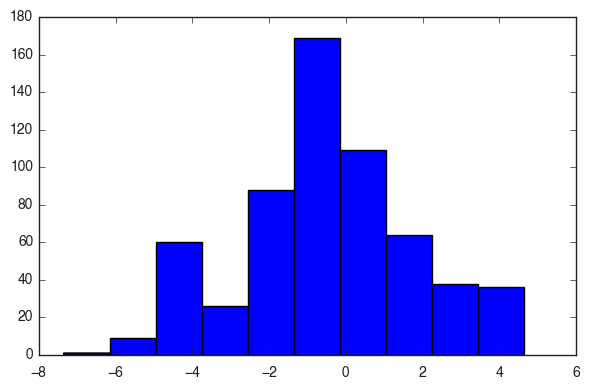

In [279]:
plt.hist(diffs)

In [268]:
private_ages = []
public_ages = []

private_junior = 0.
public_junior = 0.

for person in asst_faculty:
    if 'dblp_pubs' not in person: continue 
    junior = int(person.current == 'Assistant Professor')
    if inst[person.place]['private']:
        private_ages.append(person.first_asst_job_year)
        private_junior += junior
    else:
        public_ages.append(person.first_asst_job_year)
        public_junior += junior

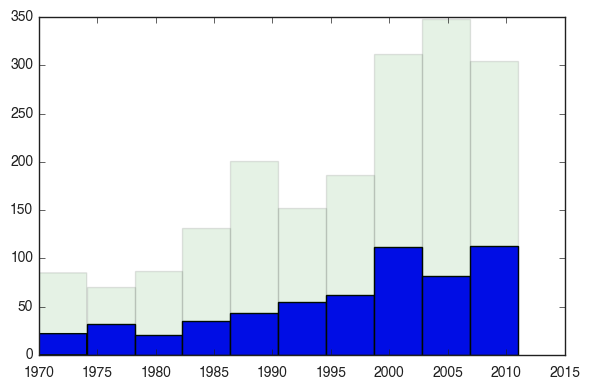

In [257]:
plt.hist(private_ages)
plt.hist(public_ages, alpha=0.1)
plt.show()

In [230]:
sp.stats.ks_2samp(private_ages, public_ages)

Ks_2sampResult(statistic=0.051318672791033693, pvalue=0.19017505849388155)

In [234]:
frac_pub = public_junior / len(public_ages)
frac_prv = private_junior / len(private_ages)

print frac_prv, frac_pub

0.230502599653 0.228144989339


In [235]:
sp.stats.binom_test(public_junior, len(public_ages), frac_prv)

0.82645552429156632

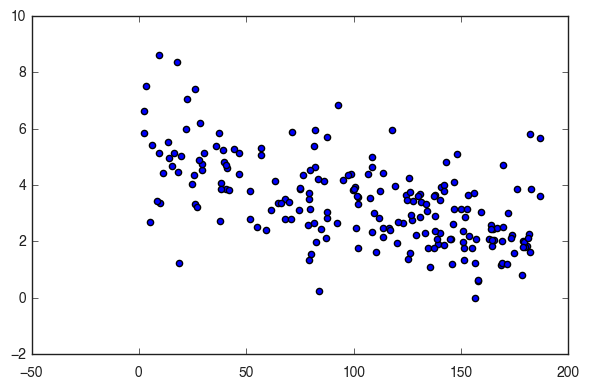

In [216]:
ranks = []
conts = []

for place in pubs_by_inst:
    ranks.append(pubs_by_inst[place]['rank'])
    conts.append(pubs_by_inst[place]['total_pubs_by_author'])
    
plt.scatter(ranks, conts)

## First-x years

In [56]:
pubs_by_inst_five, prestige_map_five = publication_data(function=np.mean, limit_by_years_post_hire=True, num_years=10)

In [52]:
total_trials = 0
num_positive = 0
advantages = []
diffs = []
rank_diffs = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(private)
    
    pairs,_ = get_matched_pairs(public, private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        assert inst[p1]['private'] == 1
        assert inst[p2]['private'] == 0
        
        private_university = 0
        published_more = np.argmax([pubs_by_inst_five[p1]["total_pubs_by_author"], pubs_by_inst_five[p2]["total_pubs_by_author"]])
        
        diff = pubs_by_inst_five[p1]["total_pubs_by_author"] - pubs_by_inst_five[p2]["total_pubs_by_author"]
        diffs.append(diff)
        
        rank_diff = pubs_by_inst_five[p1]["rank"] - pubs_by_inst_five[p2]["rank"]
        rank_diffs.append(rank_diff)
        
        if private_university == published_more:
            num_positive += 1
            advantages.append(diff)
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='two-sided')
print sp.stats.ttest_1samp(diffs, popmean=0)

0.00217347341485
Ttest_1sampResult(statistic=-3.08538260334839, pvalue=0.0021266695697283525)


In [53]:
print float(num_positive) / total_trials

0.436666666667


In [54]:
total_trials

600

In [55]:
print np.median(diffs), np.mean(diffs)

-0.247251859504 -0.284726734925
